# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet을 사용한 전이 학습

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import sys

np.set_printoptions(threshold=sys.maxsize)

## Fine Tuning 없이 사용 --> Full Model download

In [2]:
# full model
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [3]:
mobilenet = Sequential([
                    hub.KerasLayer(url, input_shape=(224,224,3))]
                    )

In [4]:
mobilenet.input, mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

## PRE-TRAINED(no fine-tuning) MOBILENET 평가

임의의 사진을 internet에서 가져온다

RGB (224, 224)


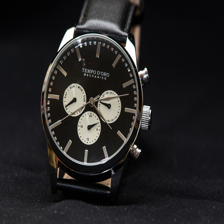

In [12]:
from PIL import Image
from urllib import request
from io import BytesIO
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((224, 224))

print(Sample_Image.mode, Sample_Image.size)
Sample_Image

image를 numpy array로 변환

In [13]:
x = preprocess_input(np.array(Sample_Image))
x.shape

(224, 224, 3)

In [16]:
predicted_class = mobilenet.predict(np.expand_dims(x, axis = 0))
predicted_class.shape

(1, 1001)

`decode_predictions` method를 이용하여 top 5 result 출력

In [17]:
decode_predictions(predicted_class[:, 1:])  # 첫번째 label은 background

49152/35363 [=========================================] - 0s 0us/step


[[('n04328186', 'stopwatch', 9.720387),
  ('n02708093', 'analog_clock', 8.041001),
  ('n03706229', 'magnetic_compass', 6.8818045),
  ('n04548280', 'wall_clock', 6.6048098),
  ('n03075370', 'combination_lock', 4.9255257)]]

Imagenet label의 종류

In [18]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


In [19]:
print(imagenet_labels[:30])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen' 'ostrich' 'brambling'
 'goldfinch' 'house finch' 'junco' 'indigo bunting' 'robin' 'bulbul' 'jay'
 'magpie' 'chickadee' 'water ouzel' 'kite' 'bald eagle' 'vulture'
 'great grey owl' 'European fire salamander' 'common newt' 'eft'
 'spotted salamander']


Text(0.5, 1.0, 'predicted class : Background')

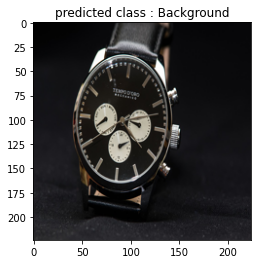

In [22]:
plt.imshow(Sample_Image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title("predicted class : " + predicted_class.title())

## 특정 domain(Flower domain)의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning 

- MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

In [23]:
# Specify path of the flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True)

228827136/228813984 [==============================] - 2s 0us/step


In [24]:
image_generator = ImageDataGenerator(
            preprocessing_function=preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path, 
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [25]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [26]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화 (`ImageDataGenerator`의  `preprocess_input`에서 normalize가 되어 있으므로 denormalize 하여 image 를 복원)

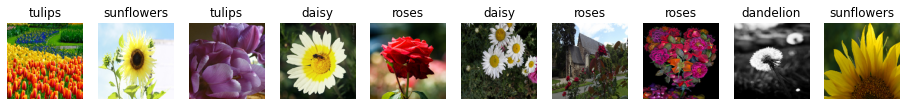

In [27]:
fig = plt.figure(figsize=(16, 8))

for i in range(10):
    sp = fig.add_subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    sp.imshow(img)
    sp.set_title(class_names[idx])
    sp.axis('off')

- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [33]:
prediction = mobilenet.predict(input_batch[2:3])
prediction.shape

(1, 1001)

In [31]:
label_batch[2]

array([0., 0., 0., 0., 1.], dtype=float32)

In [34]:
decode_predictions(prediction[:, 1:])  

[[('n04033995', 'quilt', 8.395089),
  ('n04344873', 'studio_couch', 6.8518424),
  ('n02782093', 'balloon', 5.915388),
  ('n03938244', 'pillow', 5.519263),
  ('n04591157', 'Windsor_tie', 5.5091186)]]

# 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain 

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [35]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [36]:
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [37]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [38]:
extractor_layer.trainable = False

In [39]:
# Build a model with two pieces:
#    (1)  MobileNet Feature Extractor 
#    (2)  Dense Network (classifier) added at the end 

model = Sequential([
  extractor_layer,
  Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확히 5개 category로 분류 되는지 training 전에 사전 check

In [43]:
predictions = model(input_batch)

In [44]:
predictions.shape

TensorShape([64, 5])

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 15s 210ms/step - loss: 0.7970 - accuracy: 0.7134
Epoch 2/30
58/58 [==============================] - 12s 211ms/step - loss: 0.4442 - accuracy: 0.8477
Epoch 3/30
58/58 [==============================] - 12s 206ms/step - loss: 0.3632 - accuracy: 0.8766
Epoch 4/30
58/58 [==============================] - 12s 206ms/step - loss: 0.3190 - accuracy: 0.8926
Epoch 5/30
58/58 [==============================] - 12s 209ms/step - loss: 0.2878 - accuracy: 0.9087
Epoch 6/30
58/58 [==============================] - 12s 211ms/step - loss: 0.2742 - accuracy: 0.9065
Epoch 7/30
58/58 [==============================] - 12s 211ms/step - loss: 0.2431 - accuracy: 0.9229
Epoch 8/30
58/58 [==============================] - 12s 212ms/step - loss: 0.2282 - accuracy: 0.9297
Epoch 9/30
58/58 [==============================] - 12s 214ms/step - loss: 0.2073 - accuracy: 0.9362
Epoch 10/30
58/58 [==============================] - 12s 214ms/step - loss: 0.1962 - accura

# Flower 분류에 특화하여 Fine Tuning한 MODEL 평가

In [47]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

array([4, 3, 4, 0, 2, 0, 2, 2, 1, 3, 0, 2, 4, 3, 2, 3, 2, 1, 1, 0, 4, 2,
       4, 0, 1, 2, 1, 4, 0, 4, 1, 4, 3, 3, 4, 4, 3, 4, 4, 4, 0, 3, 3, 4,
       3, 2, 3, 0, 4, 0, 4, 3, 4, 4, 0, 0, 1, 4, 1, 3, 0, 2, 1, 4])

In [48]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([4, 3, 4, 0, 2, 0, 2, 2, 1, 3, 0, 2, 4, 3, 2, 3, 2, 1, 1, 0, 4, 2,
       4, 0, 1, 2, 1, 4, 0, 4, 1, 4, 3, 3, 4, 4, 3, 4, 4, 4, 0, 3, 3, 4,
       3, 2, 3, 0, 4, 0, 4, 3, 4, 4, 0, 0, 1, 4, 1, 3, 0, 2, 1, 4])

In [50]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'100.00 %'

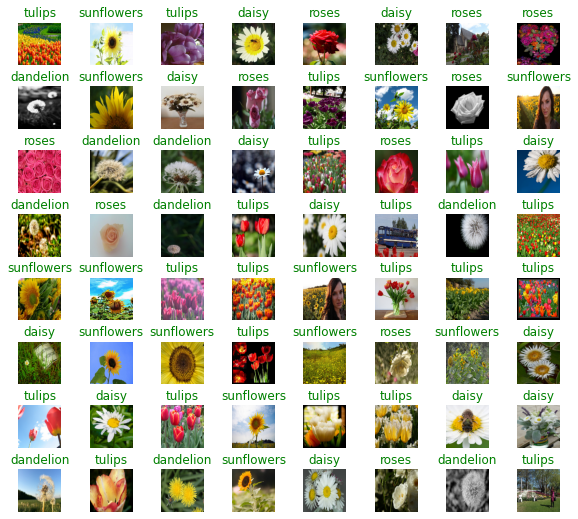

In [51]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
